# PHY 266 HW 7

In [1]:
import numpy as np
import scipy.stats as sp
import matplotlib.pyplot as plt
import glob
import astropy.units as u

from matplotlib.patches import Ellipse
from math import pi
from scipy.optimize import leastsq, least_squares, curve_fit
from astropy.cosmology import Planck15 as cosmo
from astropy.cosmology import FlatLambdaCDM 


## Prb 1. Confidence intervals

### 1 a) 

In [2]:
data = np.loadtxt('../data/union-supernova-catalog.txt')
z = data[:,0]
DM = data[:,1]*u.mag
sigma = data[:,2]
n = len(z)

In [3]:
num_H = 61    # number of points in the H axis of the grid
num_Om = 60    # number of points in the Omega_m axis of the grid

H_vals = np.linspace(60, 80, num_H)
Om_vals = np.linspace(0.0,1.0,num_Om)

In [4]:
log_L = np.zeros((num_H, num_Om))
chi_2 = np.zeros((num_H, num_Om))

for i, HO in enumerate(H_vals):
    for j, Om in enumerate(Om_vals):
        cosmo = FlatLambdaCDM(H0=HO * u.km / u.s / u.Mpc, Om0=Om)
        #print(cosmo)
        DM_model = cosmo.distmod(z)
        #print(DM_model[20:30])
        chi2 = np.sum(((DM - DM_model) / sigma).value**2)
        #print(0.5*chi2)
        log_L[i][j] = -0.5*chi2
        chi_2[i][j] = chi2

In [5]:
X,Y = np.meshgrid(Om_vals, H_vals)

In [6]:
print('minimum of chi^2 : %f' %chi_2.min())
print('\nchi^2 value that enclose the 68.3%% confidence region : %f' %(chi_2.min() + 2.2977))
print('\nchi^2 value that enclose the 95.5%% confidence region : %f' %(chi_2.min() + 6.1801))
print('\nchi^2 value that enclose the 99.7%% confidence region : %f' %(chi_2.min() + 11.829))

minimum of chi^2 : 525.218248

chi^2 value that enclose the 68.3% confidence region : 527.515948

chi^2 value that enclose the 95.5% confidence region : 531.398348

chi^2 value that enclose the 99.7% confidence region : 537.047248


Text(0.5, 0, '$\\Omega_{m0}$')

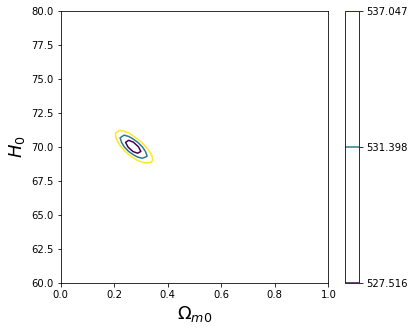

In [9]:
#plt.contour(X,Y,log_L,20)
#plt.contour(X,Y,chi_2,20)
plt.figure(figsize=(6,5))
plt.contour(X,Y,chi_2, [chi_2.min() + 2.2977,  chi_2.min() + 6.1801, chi_2.min() + 11.829])
plt.colorbar()
plt.ylabel(r'$H_0$', fontdict={'fontsize':18})
plt.xlabel(r'$\Omega_{m0}$', fontdict={'fontsize':18})

### 1 b) That would be misleading because by fixing $H_o$ we may miss those values of $\Omega_m$ which may also result in a $\chi^2$ value within the desired range of minimum $\chi^2$ for other $H_o$ values. As a reult we will underestimate the uncertainty. 

## Prb 2. Least-squares fitters: bakeoff

### 2a)

In [10]:
def residual_func(guess):
    HO = guess[0]
    Om = guess[1]
    cosmo = FlatLambdaCDM(H0=HO * u.km / u.s / u.Mpc, Om0=Om)
    #print(cosmo)
    DM_model = cosmo.distmod(z)
    #print(DM_model[20:30])
    residual = ((DM - DM_model) / sigma).value
    #chi2 = np.sum(((DM - DM_model) / sigma).value**2)
    
    return residual

In [11]:
ml_val, cov, infodict, msg, ler = leastsq(residual_func, [72, 0.3], full_output=True)

In [12]:
print('maximum likelihood values and 1-sigma uncertainty:')
print('\nHO : %f   1-sigma uncertainty : %f' %(ml_val[0], np.sqrt(cov[0][0])))
print('\nOm : %f   1-sigma uncertainty : %f' %(ml_val[1], np.sqrt(cov[1][1])))

maximum likelihood values and 1-sigma uncertainty:

HO : 70.012882   1-sigma uncertainty : 0.357576

Om : 0.270262   1-sigma uncertainty : 0.020472


### 2 b)

In [13]:
result = least_squares(residual_func,  [72, 0.3])

In [14]:
J = result['jac']
cov_1 = np.linalg.inv(np.matmul(J.T, J))

In [15]:
print('maximum likelihood values and 1-sigma uncertainty:')
print('\nHO : %f   1-sigma uncertainty : %f' %(result['x'][0], np.sqrt(cov_1[0][0])))
print('\nOm : %f   1-sigma uncertainty : %f' %(result['x'][1], np.sqrt(cov_1[1][1])))

maximum likelihood values and 1-sigma uncertainty:

HO : 70.012885   1-sigma uncertainty : 0.357572

Om : 0.270261   1-sigma uncertainty : 0.020471


### 2 c)

In [16]:
def mod_func(z, HO, Om):
    
    cosmo = FlatLambdaCDM(H0=HO * u.km / u.s / u.Mpc, Om0=Om)
    #print(cosmo)
    DM_model = cosmo.distmod(z)
    
    return DM_model.value

In [17]:
popt, pcov = curve_fit(mod_func, z, DM.value, p0=[72, .3], sigma=sigma, absolute_sigma=True)

In [18]:
print('maximum likelihood values and 1-sigma uncertainty:')
print('\nHO : %f   1-sigma uncertainty : %f' %(popt[0], np.sqrt(pcov[0][0])))
print('\nOm : %f   1-sigma uncertainty : %f' %(popt[1], np.sqrt(pcov[1][1])))

maximum likelihood values and 1-sigma uncertainty:

HO : 70.012887   1-sigma uncertainty : 0.357579

Om : 0.270261   1-sigma uncertainty : 0.020472


### 2 d)

In [27]:
mean_x = popt[1]
mean_y = popt[0]

major_axis = np.sqrt(0.5*(pcov[0][0] + pcov[1][1] + 
                                 np.sqrt((pcov[1][1] - pcov[0][0])**2 + 4*pcov[0][1]**2)))
minor_axis = np.sqrt(0.5*(pcov[0][0] + pcov[1][1] - 
                                 np.sqrt((pcov[1][1] - pcov[0][0])**2 + 4*pcov[0][1]**2)))
angle = np.degrees(0.5*np.arctan2(2*pcov[0][1], pcov[1][1]-pcov[0][0]))
                  
myellipse = Ellipse(xy=[mean_x, mean_y], width=2*1.52*major_axis, height=2*1.52*minor_axis, 
                    angle=angle, fill=False)

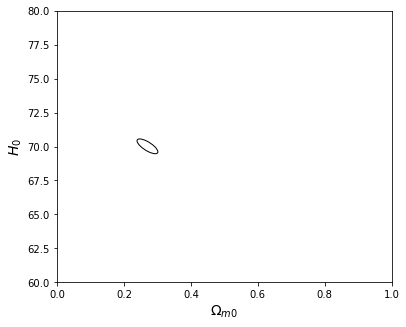

In [28]:
f = plt.figure(figsize=(6,5))
ax = f.add_subplot(111)
#ax.scatter(, Y, s=2)
ax.set_ylim(60, 80)
ax.set_xlabel(r'$\Omega_{m0}$', fontdict={'fontsize':14})
ax.set_ylabel(r'$H_0$', fontdict={'fontsize':14})
ax.add_artist(myellipse)
#plt.grid(True, which='both')

### It seems the 68.3% CI  ellipse matches with the one in peoblem 1.

### 2 e)

### Yes, the errorbars on the supernovae are believable. In problem 1 we have calculated the 68.3% confidance interval using the $\Delta \chi^2$ method. If the errorbars where not valid then they would not have lead to a covariance matrix using which we can also reach to same confidence interval.

### 2 f)

### The optimizer approach is generally faster than the grid approach. The optimizer approach may become slower if it gets stuck in some local maxima. The covariance matrix provided in optimizer approach may not be relaiable to calculate confidence interval if the error estimates were not good. On the other hand using $\Delta \chi^2$ method in grid approach we can get relaiable joint confidence interval for the parameters.

## Prb 3. Fisher matix

### 3 a) The Fisher matrix $F$ assuming Gaussian uncertainty and a model f(x) with parameters $a_l$ is defined as $F_{jk} = \sum_i \frac{1}{\sigma_i^2}\frac{\partial f(x_i)}{\partial a_j}\frac{\partial f(x_i)}{\partial a_k} $. For the given linear model $y=ax+b$, the Fisher matrix is then 
$\begin{vmatrix}
\sum_i \frac{x_i^2}{\sigma_i^2}  &  \sum_i \frac{x_i}{\sigma_i^2} \\
\sum_i \frac{x_i}{\sigma_i^2}    &  \sum_i  \frac{1}{\sigma_i^2}  \\
\end{vmatrix}$


### 3 b) 

In [29]:
def inv_fisher_matrix(obsrv_points, sigma):
    """
    This function computes the fisher matrix and returns the
    inverse of the matrix for a two
    parameter linear model given the array of observation
    points and associated uncertainties. 
    """
    
    fisher_mat = np.array([[np.sum(obsrv_points**2 / sigma), np.sum(obsrv_points / sigma)],
                          [np.sum(obsrv_points / sigma), np.sum(1 / sigma)]])
    print('Fisher matrix:\n')
    print(fisher_mat)
    
    inv_fisher_mat = np.linalg.inv(fisher_mat)
    
    print('\nInverse of Fisher matrix:\n')
    print(inv_fisher_mat)
    
    return inv_fisher_mat

In [30]:
obsrv_points = np.linspace(-1, 1, 20)
sigma = np.ones(obsrv_points.shape) * 0.01

In [31]:
a = inv_fisher_matrix(obsrv_points, sigma)

Fisher matrix:

[[ 7.36842105e+02 -1.70530257e-13]
 [-1.70530257e-13  2.00000000e+03]]

Inverse of Fisher matrix:

[[1.35714286e-03 1.15716960e-19]
 [1.15716960e-19 5.00000000e-04]]


### 3 c) I need to invent only x values or where the observation will take place. As the Fisher matrix elements depends on the derivative of y with respect to model parameters only inventing x values will suffice to calculate Fisher matrix elements.

### 3 d) Minimizing covariance

In [32]:
obsrv_points1 = np.linspace(-1.0, 1.0, 100)
sigma1 = np.ones(obsrv_points1.shape) * 0.5

min_cov = inv_fisher_matrix(obsrv_points1, sigma1)

Fisher matrix:

[[6.80134680e+01 1.64313008e-14]
 [1.64313008e-14 2.00000000e+02]]

Inverse of Fisher matrix:

[[ 1.47029703e-02 -1.20794464e-18]
 [-1.20794464e-18  5.00000000e-03]]


### Maximizing covariance

In [34]:
obsrv_points2 = np.linspace(0.0, 1.0, 100)
sigma2 = np.ones(obsrv_points2.shape) * 0.1

max_cov = inv_fisher_matrix(obsrv_points2, sigma2)

Fisher matrix:

[[ 335.01683502  500.        ]
 [ 500.         1000.        ]]

Inverse of Fisher matrix:

[[ 0.01176238 -0.00588119]
 [-0.00588119  0.00394059]]


### We could choose our observation points in such a way that it would minimize the covariance between parameters. 